# Model creation (2x2)

In [57]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
# Imports
import dill
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tools import common_functions as cf
from tools import regression as reg
from tools import plotting_functions as pf

# Folder prefix with all the taxel data
TAXEL_DATA_FOLDER = f"table_calibration/remko5_003_taxel"


# Parameters
SENSOR_LAG = 100 # ms
ARRAY_SIZE = 4

# Automated
data_columns = [f'X{i}' for i in range(ARRAY_SIZE)] + [f'Y{i}' for i in range(ARRAY_SIZE)] + [f'Z{i}' for i in range(ARRAY_SIZE)]

In [59]:
taxels_data = []

for i in range(ARRAY_SIZE):
  
  # Load the data
  taxel_data = cf.prepare_data_for_fitting(f"{TAXEL_DATA_FOLDER}{i}", ARRAY_SIZE, SENSOR_LAG, False)
  taxels_data.append(taxel_data)

In [66]:
models = []
predictions = []

for i in range(ARRAY_SIZE):
  
  taxel_data = taxels_data[i]
  
  # Fit the 0.5Hz data to a third order polynomial model
  columns = [f'X{i}', f'Y{i}',f'Z{i}']

  X = taxel_data[columns]#[:int(len(taxel_data) / 2)]
  Y = taxel_data[['F_x', 'F_y', 'F_z']]#[:int(len(taxel_data) / 2)]
  
  print(f"\nFitting taxel {i}:")
  model = reg.create_regression_pipeline_and_fit(X.values, Y, True, alpha=1)
  model.taxel_index = i
  models.append(model)


Fitting taxel 0:
Score:  0.8333301822827442
MSE:  0.6054883159053933

Fitting taxel 1:
Score:  0.7653828537816633
MSE:  1.0942434265037857

Fitting taxel 2:
Score:  0.39825316858380067
MSE:  2.3484700541741597

Fitting taxel 3:
Score:  0.6836447851842854
MSE:  1.398512150342924


In [61]:
for model in models:
  reg.save_taxel_models(model, f"remko", f"5_taxel{model.taxel_index}")
#models = [models[3], models[2], models[0], models[1]]
reg.save_taxel_models(models, f"remko", f"remko-2x2-5-007")

# Testing

In [62]:
taxel_models = dill.load(open('../models/remko/remko-2x2-5-007', 'rb'))
taxels_data = []
for i in range(ARRAY_SIZE):
  # Load the data
  taxel_data = cf.prepare_data_for_fitting(f"{TAXEL_DATA_FOLDER}{i}", ARRAY_SIZE, SENSOR_LAG, False)
  taxels_data.append(taxel_data)

In [63]:
taxel_idx = 0
data = taxels_data[taxel_idx][[f'X{taxel_idx}', f'Y{taxel_idx}',f'Z{taxel_idx}']]#[:int(len(taxel_data))]
#print(data)
true = taxels_data[taxel_idx][['F_x', 'F_y', 'F_z']]#[:int(len(taxel_data))]
prediction = taxel_models[taxel_idx].predict(data.values)

MSE: 0.6055072026436167


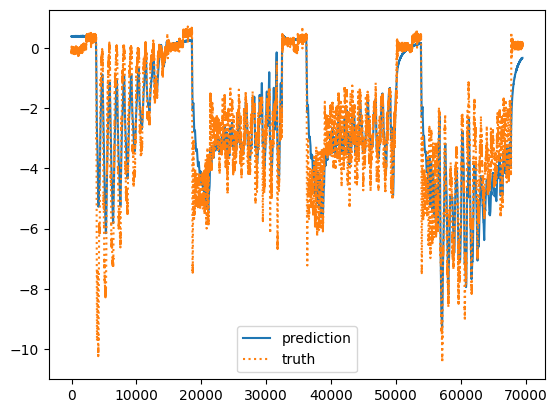

In [64]:
from sklearn.metrics import mean_squared_error


axis = 2
plt.plot(prediction[:, axis], label='prediction')
plt.plot(true.values[:, axis], linestyle='dotted', label='truth')
#plt.ylim((-2, 2))
#plt.xlim([0, 150000])
plt.legend()

print(f'MSE: {mean_squared_error(true.values, prediction)}')

## Live Testing

In [74]:
import time
from tools.measuring import InferenceInterface
from tools.controller import *
import rtde_control, rtde_receive

ROBOT_HOST = "10.42.0.162" # IP address of the robot

rtde_r = rtde_receive.RTDEReceiveInterface(ROBOT_HOST)
rtde_c = rtde_control.RTDEControlInterface(ROBOT_HOST)
controller = CalibrationController(rtde_r, rtde_c)

measuring_interface = InferenceInterface(controller, taxel_models)

In [77]:
measuring_interface.start_measuring("tmp")

Exception in thread Thread-9:
Traceback (most recent call last):
  File "/home/idlab403/anaconda3/envs/thesis-lowiek/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/home/idlab403/anaconda3/envs/thesis-lowiek/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/home/idlab403/Documents/Doctoraat/Projects/thesis-lowiek/notebooks/tools/sensor_reader.py", line 311, in interpret_and_publish_sensor_sync
    csvrow.append(row[f"X{i}"])
KeyError: 'X0'
